# Test with library osmnx

https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873

https://osmnx.readthedocs.io/en/stable/index.html

## 0) Setup

In [107]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings

In [108]:
# Downloading the map as a graph object
G_osmnx = ox.graph_from_bbox(north = 48.00877, south = 48.00373,
                        east = 7.84336, west = 7.83252, network_type = 'all')

# area from old osm xml file: north = 48.0081, south = 48.0048, east = 7.8391, west = 7.8357

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

network_type (string {"all_private", "all", "bike", "drive", "drive_service", "walk"}) – what type of street network to get if custom_filter is None

In [109]:
print('The graph has {} nodes and {} edges.'.format(G_osmnx.number_of_nodes(), G_osmnx.number_of_edges()))

The graph has 304 nodes and 743 edges.


## 1) Analyze node information

In [110]:
# get list with all possible node attributes
node_attributes = ox.graph_to_gdfs(G_osmnx, edges=False).columns
print('The following node attributes are available:')
for attr in node_attributes:
    print(f'- {attr}')

The following node attributes are available:
- y
- x
- street_count
- highway
- ref
- geometry


In [111]:
# print first node
print(list(G_osmnx.nodes(data=True))[0])

(26989181, {'y': 48.0039326, 'x': 7.8371789, 'street_count': 3})


**Remark**: These attributes are not helpful enough, because we cannot define the 'special nodes'!

## 2) Analyze edge information

In [112]:
# get list with all possible edge attributes
edge_attributes = ox.graph_to_gdfs(G_osmnx, nodes=False).columns
print('The following edge attributes are available:')
for attr in edge_attributes:
    print(f'- {attr}')

The following edge attributes are available:
- osmid
- oneway
- lanes
- ref
- name
- highway
- maxspeed
- reversed
- length
- geometry
- service
- width
- tunnel
- access
- bridge


In [113]:
# print first edge
print(list(G_osmnx.edges(data=True))[0])

(26989181, 523915341, {'osmid': 230446364, 'oneway': True, 'lanes': '1', 'ref': 'K 9860', 'name': 'Breisacher Straße', 'highway': 'secondary', 'maxspeed': '50', 'reversed': False, 'length': 28.355})


 **Remark:** Missing information from osm file {'surface': 'asphalt'}.

## 3) Plot

In [114]:
# convert it to a Single Undirected Graph
G_osmnx = nx.Graph(G_osmnx)

In [115]:
# convert all node ids to strings
for node in list(G_osmnx.nodes()):
    G_osmnx = nx.relabel_nodes(G_osmnx, {node: str(node)})

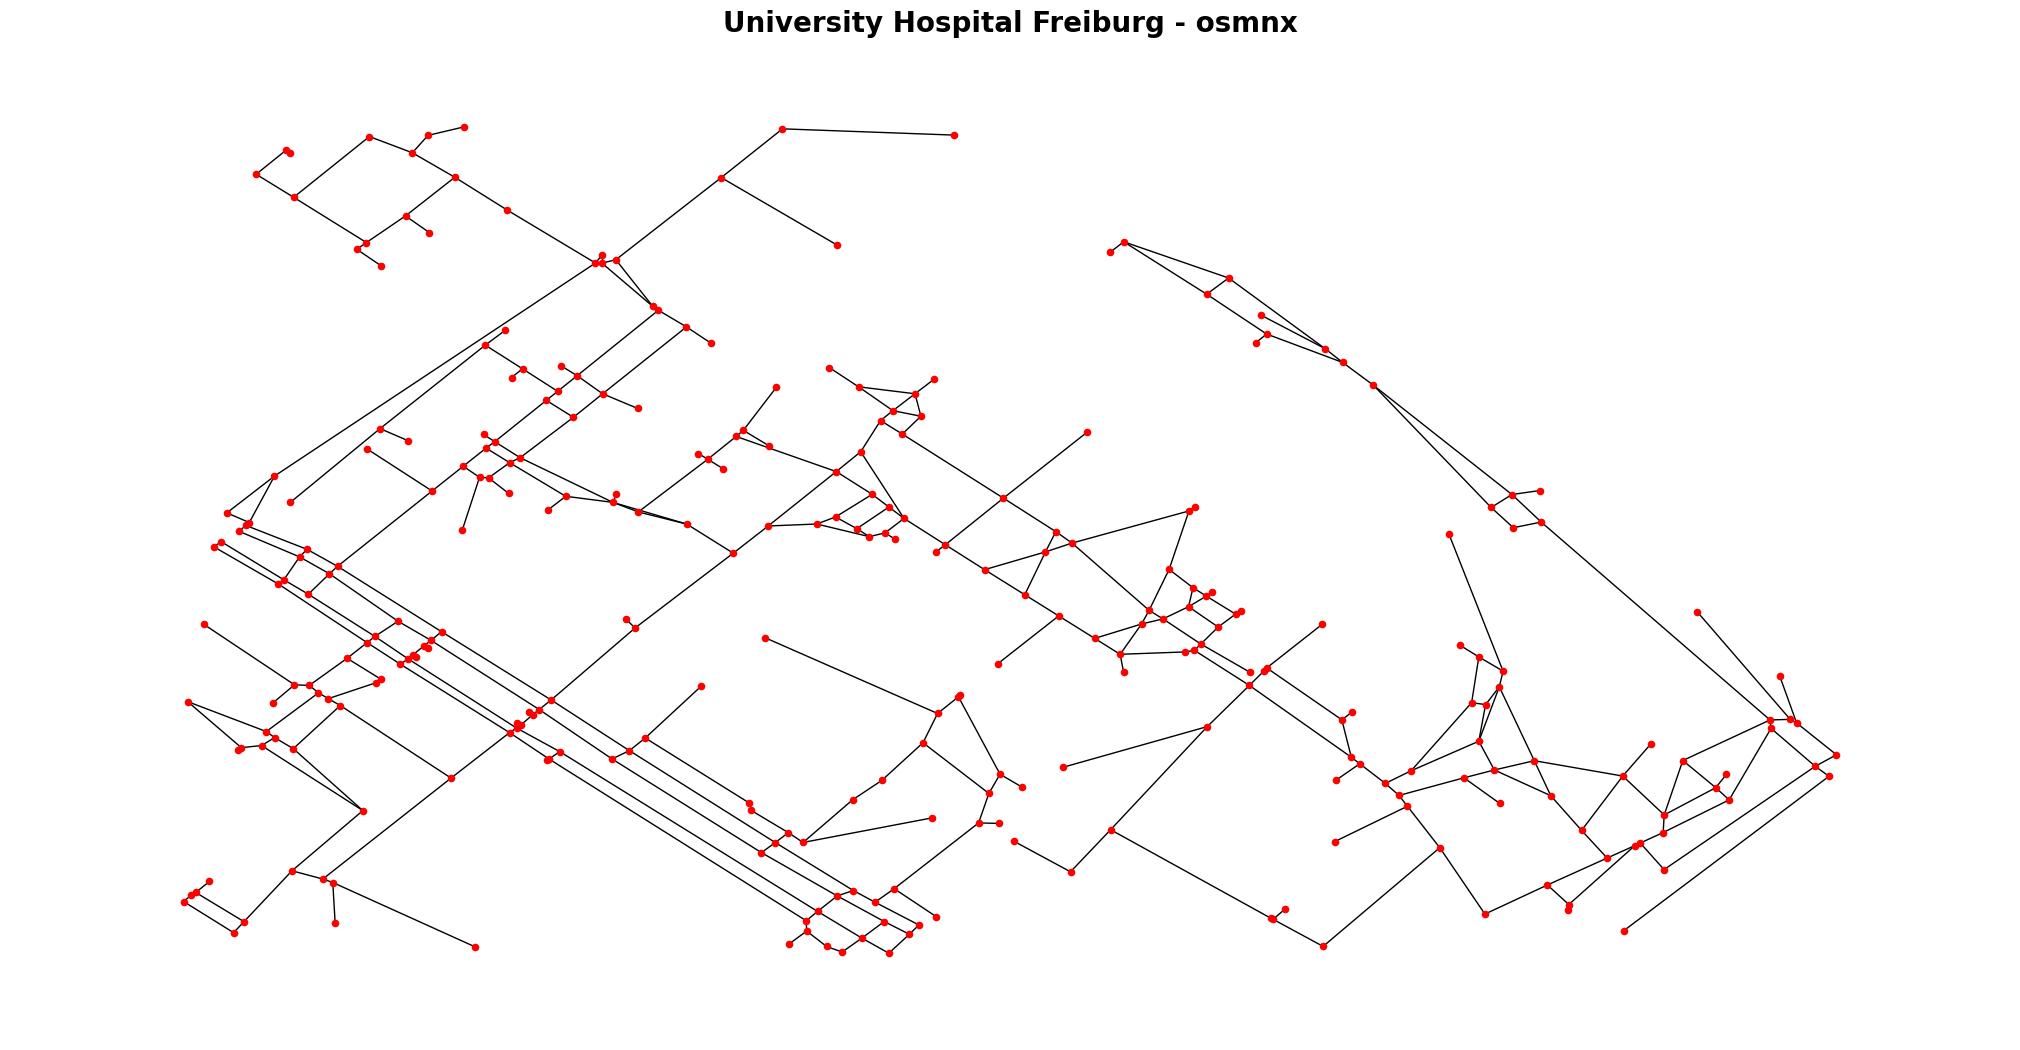

In [116]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_osmnx.nodes(data=True)}

# delete self loop
G_osmnx.remove_edges_from(nx.selfloop_edges(G_osmnx))

plt.figure(figsize=(20, 10))
nx.draw(G_osmnx, with_labels=False, node_size=20, node_color='red', edge_color='black', pos=pos, arrows=False)
plt.title('University Hospital Freiburg - osmnx', fontsize=20, fontweight='bold')
plt.show()

**Conclusion**: Use osmnx to build the graph and afterwards add missing attributes (e.g. for edges 'surface' and for nodes 'special character').

## 4) OSM XML-file

In [117]:
# reading data inside xml file to a variable under the name data
with open('Uniklinikum_Freiburg_map_v2.osm', 'r', encoding='utf-8') as f:
    data = f.read()
 
# passing stored data inside beautifulsoup parser, storing the returned object 
bs_data = BeautifulSoup(data, "xml")

In [118]:
# store all nodes in a dictionary and give them a label
nds_xml = {}
for node in bs_data.select('node'):
    # first case: store has a name
    if node.find('tag', k='name'):
        # map node id to name
        nds_xml[node['id']] = node.find('tag', k='name').get('v')
    else:
        nds_xml[node['id']] = None

# print the number of total nodes      
print('The osm-xml map includes {} total nodes before filtering.'.format(len(nds_xml.keys())))

The osm-xml map includes 6505 total nodes before filtering.


In [119]:
# create graph with all nodes from xml file
G_xml = nx.Graph()
for node in bs_data.select('node'):
    G_xml.add_node(node['id'], y = float(node['lat']), x = float(node['lon']), street_count = None)

In [120]:
print(list(G_xml.nodes(data=True))[0])

('26989179', {'y': 48.0070115, 'x': 7.8312116, 'street_count': None})


In [121]:
# store all ways in a dictionary and give them a label according to their surface type
ways = {}

for way in bs_data.select('way'):
    # manually filter out some ways
    # if way.find('tag', k='addr:street', v=' Breisacher Straße'): # v='Robert-Koch-Straße'
    #     break   
    # else:
        # filter out ways that don't have a surface tag
    if way.find('tag', k='surface'):
        # map way id to a tuple of (list of node ids, surface type)
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                        way.find('tag', k='surface').get('v'))
    else:
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                        None)

# # delete from dictionary all ways if they are part of the relation 'Hauptfriedhof Freiburg'
# for relation in bs_data.select('relation'):
#     if relation.find('tag', k='name', v='Hauptfriedhof Freiburg'):
#         for member in relation.find_all('member'):
#             if member['type'] == 'way':
#                 ways.pop(member['ref'], None)


In [122]:
list(set([way[1] for way in ways.values() if way[1] is not None]))

['grass_paver',
 'concrete',
 'ground',
 'concrete:plates',
 'paved',
 'fine_gravel',
 'grass',
 'paving_stones',
 'compacted',
 'sett',
 'cobblestone',
 'metal_grid',
 'asphalt',
 'gravel']

In [123]:
# create graph with all edges from xml file
for way_id, (nodes, surface) in ways.items():
    for i in range(len(nodes)-1):
        G_xml.add_edge(nodes[i], nodes[i+1], surface = surface)

In [124]:
# drop all nodes with degree 0 if the name is None
for node in list(G_xml.nodes(data=True)):
    if node[1]['street_count'] == None:
        if G_xml.degree[node[0]] == 0:
            G_xml.remove_node(node[0])

# # keep largest connected component
# largest_cc = max(nx.connected_components(G_xml), key=len)
# G_xml = G_xml.subgraph(largest_cc).copy()

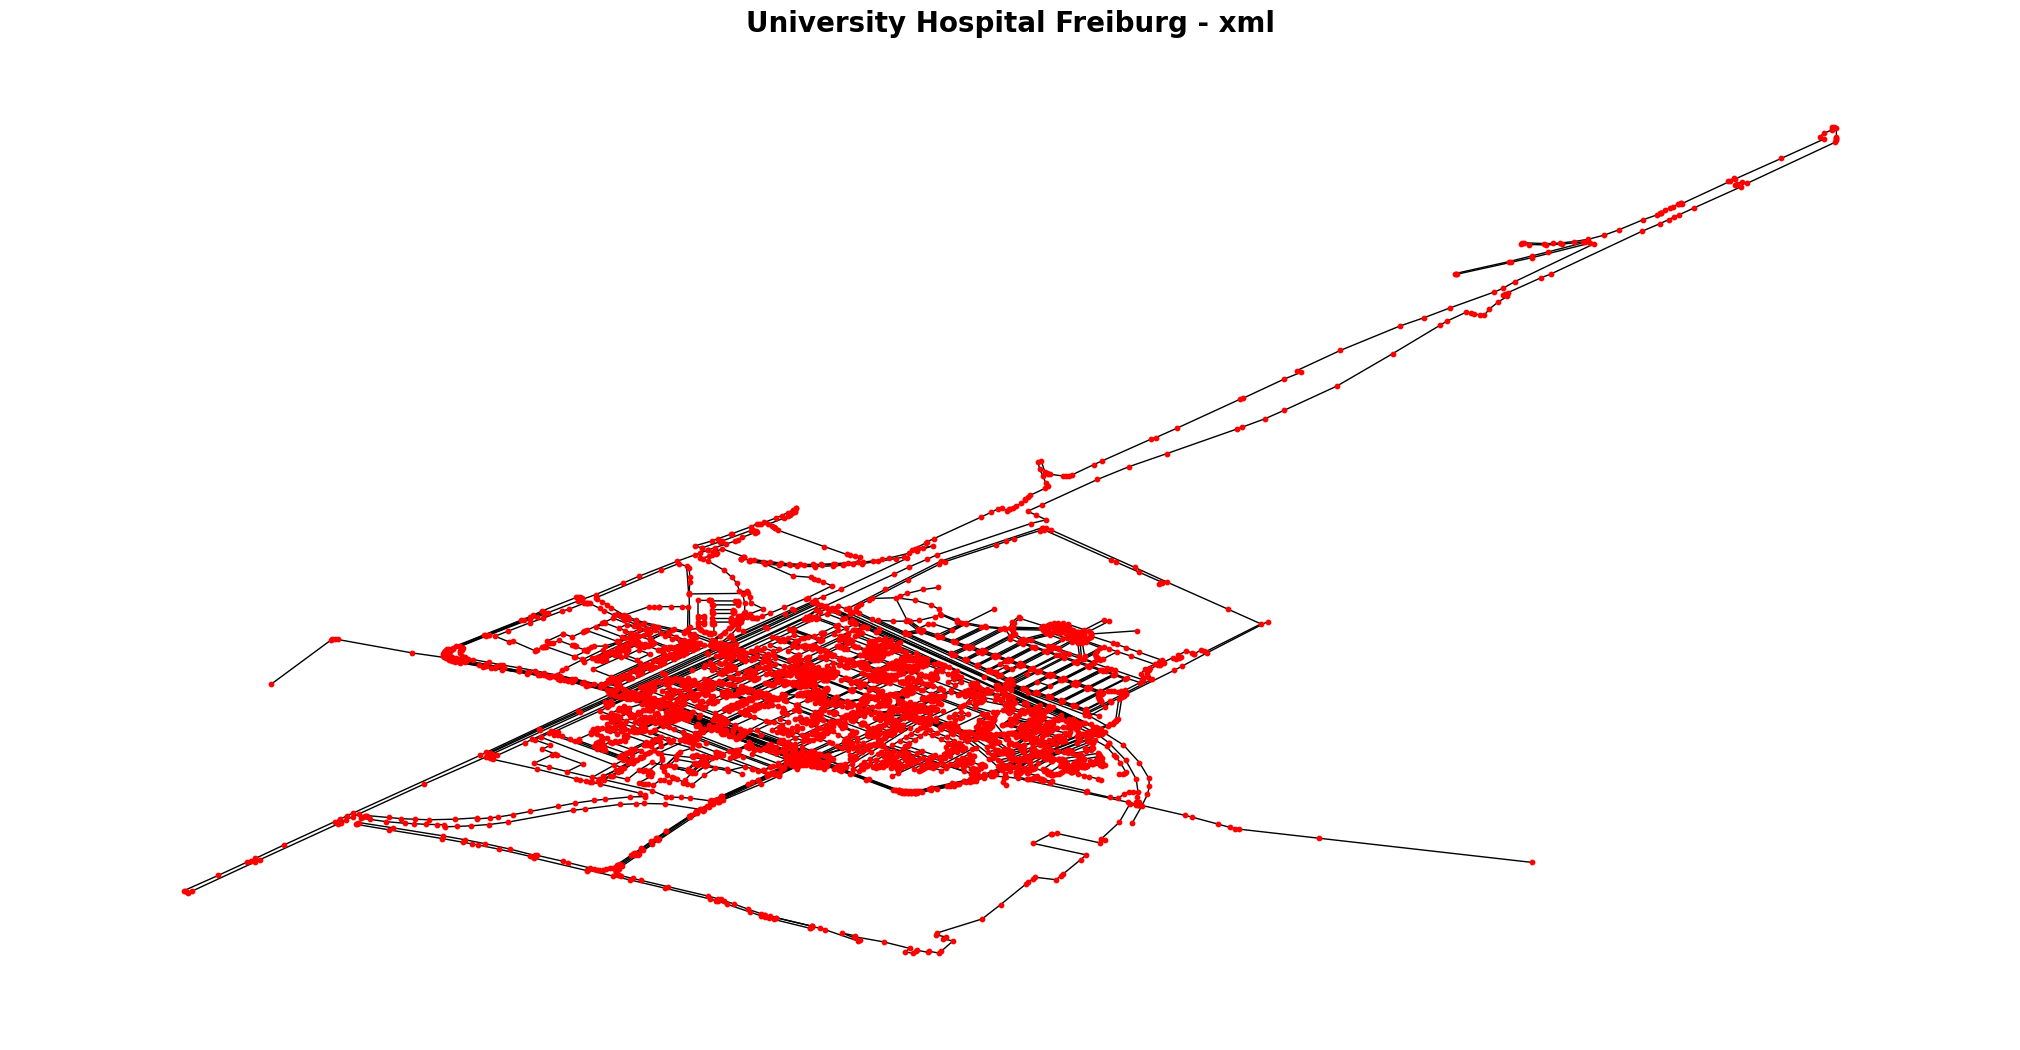

In [125]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_xml.nodes(data=True)}

plt.figure(figsize=(20, 10))
nx.draw(G_xml, with_labels=False, node_size=10, node_color='red', edge_color='black', pos=pos, arrows=False)
plt.title('University Hospital Freiburg - xml', fontsize=20, fontweight='bold')
plt.show()

## 5) Graph adaption

In [126]:
# # get from xml file a list of nodes that are part of a way with the name 'Breisacher Straße'
# nodes_brei_str = []
# for way in bs_data.select('way'):
#     if way.find('tag', k='name', v='Breisacher Straße'):
#         for nd in way.find_all('nd'):
#             nodes_brei_str.append(nd['ref'])

In [127]:
# now filter the nodes to only include those that are part of the osmnx graph
nds_final = {k: v for k, v in nds_xml.items() if int(k) in G_osmnx.nodes} #and int(k) not in nodes_brei_str}

# print the number of total nodes      
print('The map includes {} total nodes after filtering.'.format(len(nds_final.keys())))

The map includes 0 total nodes after filtering.


In [128]:
# print ids where value is not None
print(f'The following {len([v for k,v in nds_final.items() if v is not None])} nodes of the osmnx graph have names:')
for k, v in nds_final.items():
    if v is not None:
        print(f'- {k}: {v}')

The following 0 nodes of the osmnx graph have names:


In [129]:
# add special nodes from xml graph
special_nodes = ['Emmaus Kapelle', 'Apotheke des Universitätsklinikums',
                 'Neurozentrum', 'Café am Ring', 'Die Andere Galerie', 'Augenklinik / HNO',
                 'Tonus', 'Neurozentrum', 'Café am Eck', 'Bistro am Lorenzring',
                 'Urologie', 'Luther Kindergarten', 'Kiosk Frauenklinik', 'Ernährungsmedizin',
                 'Medienzentrum', '3SAM Tagespflege', 'Klinik für Onkologische Rehabilitation',
                 'Stimme vom Berg', 'Klinik für Frauenheilkunde', 'Cafeteria im Casino',
                 'Sympathy', 'Die Himmelsleiter', 'Zwischen den Räumen',
                 'Terrakotta', 'Große Kugelkopfsäule', 'Freischwimmer', 'Notaufnahme', 'Gum',
                 'Tripylon', 'Notfallpraxis der niedergelassenen Ärzte', 'Klinik für Palliativmedizin',
                 'Lebensalter', 'Blutspende Freiburg', 'Christian Daniel Nussbaum','Das große Spiel',
                 'Hippokrates von Kos', 'Theodor Billroth',
                 'Adolf Lorenz', 'Universitätsklinikum Freiburg - Klinik für Innere Medizin']

special_nodes_xml_index = [k for k,v in nds_xml.items() if v in special_nodes]
special_nodes_xml_names = [v for k,v in nds_xml.items() if v in special_nodes]

# special_nodes = ['Freiburg Klinikum', 'Robert-Koch-Straße', 'Robert-Koch-Straße',
#                  'The Holy Taco Shack', 'Emmaus Kapelle', 'Rathaus im Stühlinger',
#                  'Robert-Koch-Straße', 'Robert-Koch-Straße', 'Robert-Koch-Straße',
#                  'Friedrich-Ebert-Platz', 'Apotheke des Universitätsklinikums',
#                  'Neurozentrum', 'Café am Ring', 'Die Andere Galerie', 'Augenklinik / HNO',
#                  'Tonus', 'Neurozentrum', 'Café am Eck', 'Bistro am Lorenzring',
#                  'Robert-Koch-Straße', 'Berliner Allee', 'Killianstraße', 'Killianstraße',
#                  'Urologie', 'Luther Kindergarten', 'Kiosk Frauenklinik', 'Ernährungsmedizin',
#                  'Medienzentrum', 'Reiß-Beck', '3SAM Tagespflege', 'Klinik für Onkologische Rehabilitation',
#                  'Stimme vom Berg', 'Klinik für Frauenheilkunde', 'Cafeteria im Casino',
#                  'Klinik für Frauenheilkunde', 'Sympathy', 'Die Himmelsleiter', 'Zwischen den Räumen',
#                  'Terrakotta', 'Große Kugelkopfsäule', 'Freischwimmer', 'Notaufnahme', 'Gum',
#                  'Tripylon', 'Notfallpraxis der niedergelassenen Ärzte', 'Klinik für Palliativmedizin',
#                  'ohne Titel', 'Lebensalter', 'frelo Friedrich-Ebert-Platz', 'frelo Killianstraße',
#                  'Blutspende Freiburg', 'Christian Daniel Nussbaum', 'Freiburg Klinikum','Das große Spiel',
#                  'Die Spur', 'R.K. Asia Shop', 'Zwei Wandreliefs', 'Hermann Nothnagel', 'Paracelsus',
#                  'Herman Boerhaave', 'Johann Lukas Schönlein', 'Hippokrates von Kos', 'Theodor Billroth',
#                  'Ernst von Bergmann', 'Joseph Lister', 'Ambroise Paré', 'Guy de Chauliac', 'Adolf Lorenz',
#                  'Universitätsklinikum Freiburg - Klinik für Innere Medizin', 'Blutkunst','Friseur Elly Frey',
#                  'Sallivita Kosmetik', 'Hartmannstraße', 'DHL Packstation 191', 'Creativ Coiffeur Löffler']


# # manually delete the nodes 'Berliner Allee' [2x] and 'Rathaus im Stühlinger' [2x] as they are too far away
# special_nodes_xml_index.remove('3137144829')
# special_nodes_xml_index.remove('3137144830')
# special_nodes_xml_names.remove('Berliner Allee')
# special_nodes_xml_index.remove('31683731')
# special_nodes_xml_index.remove('611622282')
# special_nodes_xml_names.remove('Rathaus im Stühlinger')

In [130]:
nds_xml = {}
for node in bs_data.select('node'):
    # first case: store has a name
    if node.find('tag', k='name'):
        # map node id to a tuple of (lat, lon, name)
        nds_xml[node['id']] = (node['lat'], node['lon'], node.find('tag', k='name').get('v'))
    else:
        nds_xml[node['id']] = (node['lat'], node['lon'], None)

In [131]:
# create final graph
G_final = G_osmnx.copy()

# manually delete the upper part of the graph
G_final.remove_node('31452921')
# only keep largest connected component
largest_cc = max(nx.connected_components(G_final), key=len)
G_final = G_final.subgraph(largest_cc).copy()

NetworkXError: The node 31452921 is not in the graph.

In [ ]:
# add special nodes from xml graph
for i in range(len(special_nodes_xml_index)):
    G_final.add_node(special_nodes_xml_index[i],
                     y = float(bs_data.find('node', id=special_nodes_xml_index[i])['lat']),
                     x = float(bs_data.find('node', id=special_nodes_xml_index[i])['lon']),
                     name = special_nodes_xml_names[i])

In [ ]:
# add surface type to edges from information about ways
edge_surface = {}

for way_id, (nodes, surface) in ways.items():
    for i in range(len(nodes)-1):
        for j in range(1,len(nodes)):
            if (int(nodes[i]), int(nodes[j])) in G_final.edges:
                edge_surface[(int(nodes[i]), int(nodes[j]))] = surface # key = 0

In [ ]:
# add surface type to final graph
nx.set_edge_attributes(G_final, edge_surface, 'surface')
print(nx.get_edge_attributes(G_final, 'surface'))

# add names of special nodes to final graph
nx.set_node_attributes(G_final, nds_final, name = 'name')
print(nx.get_node_attributes(G_final, 'name'))

{(26989181, 523915341): 'asphalt', (26989181, 585142663): 'asphalt', (26989181, 523915329): 'asphalt', (27362932, 3350449609): None, (27362932, 245004113): 'asphalt', (27673813, 5851719444): 'asphalt', (27673813, 245004113): 'asphalt', (27794974, 798211818): 'asphalt', (29077986, 9082997203): 'asphalt', (29077986, 249261813): 'asphalt', (29077986, 29077987): 'asphalt', (29077987, 8023469821): 'paving_stones', (29077988, 8023469821): 'paving_stones', (31404358, 7055172851): 'asphalt', (31404358, 31404360): 'asphalt', (31404358, 8243547362): 'asphalt', (31404360, 7535556147): 'asphalt', (31404360, 7120224714): 'asphalt', (31404363, 31404367): 'asphalt', (31404364, 313157654): 'paving_stones', (31404364, 313157656): 'asphalt', (31404364, 1280377578): 'paving_stones', (31404364, 31404367): 'asphalt', (31404367, 313157654): 'asphalt', (31413756, 660196443): 'asphalt', (31413756, 523915341): 'asphalt', (31413756, 585142663): 'asphalt', (31451750, 245411481): None, (31451750, 7273047832): Non

In [ ]:
# get a list with all possible highway types
highway_types = []
for way in bs_data.select('way'):
    if way.find('tag', k='highway'):
        highway_types.append(way.find('tag', k='highway').get('v'))

list(set(highway_types))

['platform',
 'pedestrian',
 'cycleway',
 'residential',
 'path',
 'tertiary',
 'secondary',
 'construction',
 'unclassified',
 'steps',
 'footway',
 'secondary_link',
 'service']

In [ ]:
print(len(nx.get_edge_attributes(G_final, 'surface').values()))
print(len(G_final.edges()))

316
373


In [ ]:
G_xml.edges()

EdgeView([('26989179', '2146277941'), ('26989179', '2894471488'), ('26989181', '2926375880'), ('26989181', '523915341'), ('26989181', '523915329'), ('26997459', '2926375883'), ('26997459', '4567769659'), ('26997459', '8755540194'), ('26997459', '3537801977'), ('27010894', '27594973'), ('27010894', '2867080636'), ('27010894', '7729029175'), ('27010894', '8490012781'), ('27010894', '27010898'), ('27010897', '2867080636'), ('27010897', '11146286784'), ('27010897', '7118236341'), ('27010898', '6496083829'), ('27010898', '7729029175'), ('27010898', '7118236343'), ('27362932', '9082997205'), ('27362932', '1213134253'), ('27362932', '3350449609'), ('27362932', '7273047833'), ('27589962', '9891122764'), ('27589962', '8085761350'), ('27594973', '251497644'), ('27594973', '7689280278'), ('27594976', '5899051405'), ('27594982', '1660262942'), ('27666855', '2109367680'), ('27666855', '2583519442'), ('27666858', '10252819514'), ('27666858', '3584334884'), ('27666859', '10017801607'), ('27666859', '

In [ ]:
G_final.edges()

EdgeView([(26989181, 523915341), (26989181, 585142663), (26989181, 523915329), (27362932, 3350449609), (27362932, 245004113), (27362932, 7273047832), (27362932, 5865585831), (27673813, 5851719444), (27673813, 29077988), (27673813, 245004113), (27794974, 798211818), (27794974, 3344424409), (29077986, 9082997203), (29077986, 249261813), (29077986, 29077987), (29077987, 8023469821), (29077988, 8023469821), (31404358, 7055172851), (31404358, 31404360), (31404358, 8243547362), (31404360, 7535556147), (31404360, 7120224714), (31404363, 31404367), (31404364, 313157654), (31404364, 313157656), (31404364, 1280377578), (31404364, 31404367), (31404367, 313157654), (31413756, 660196443), (31413756, 523915341), (31413756, 585142663), (31413756, 11292850730), (31451750, 245411481), (31451750, 7273047832), (31451750, 245411483), (31451750, 313159740), (31451751, 7047823175), (31451751, 245411475), (31451751, 245411472), (31451751, 245411491), (31451759, 7037104959), (31451759, 245004120), (31451759, 

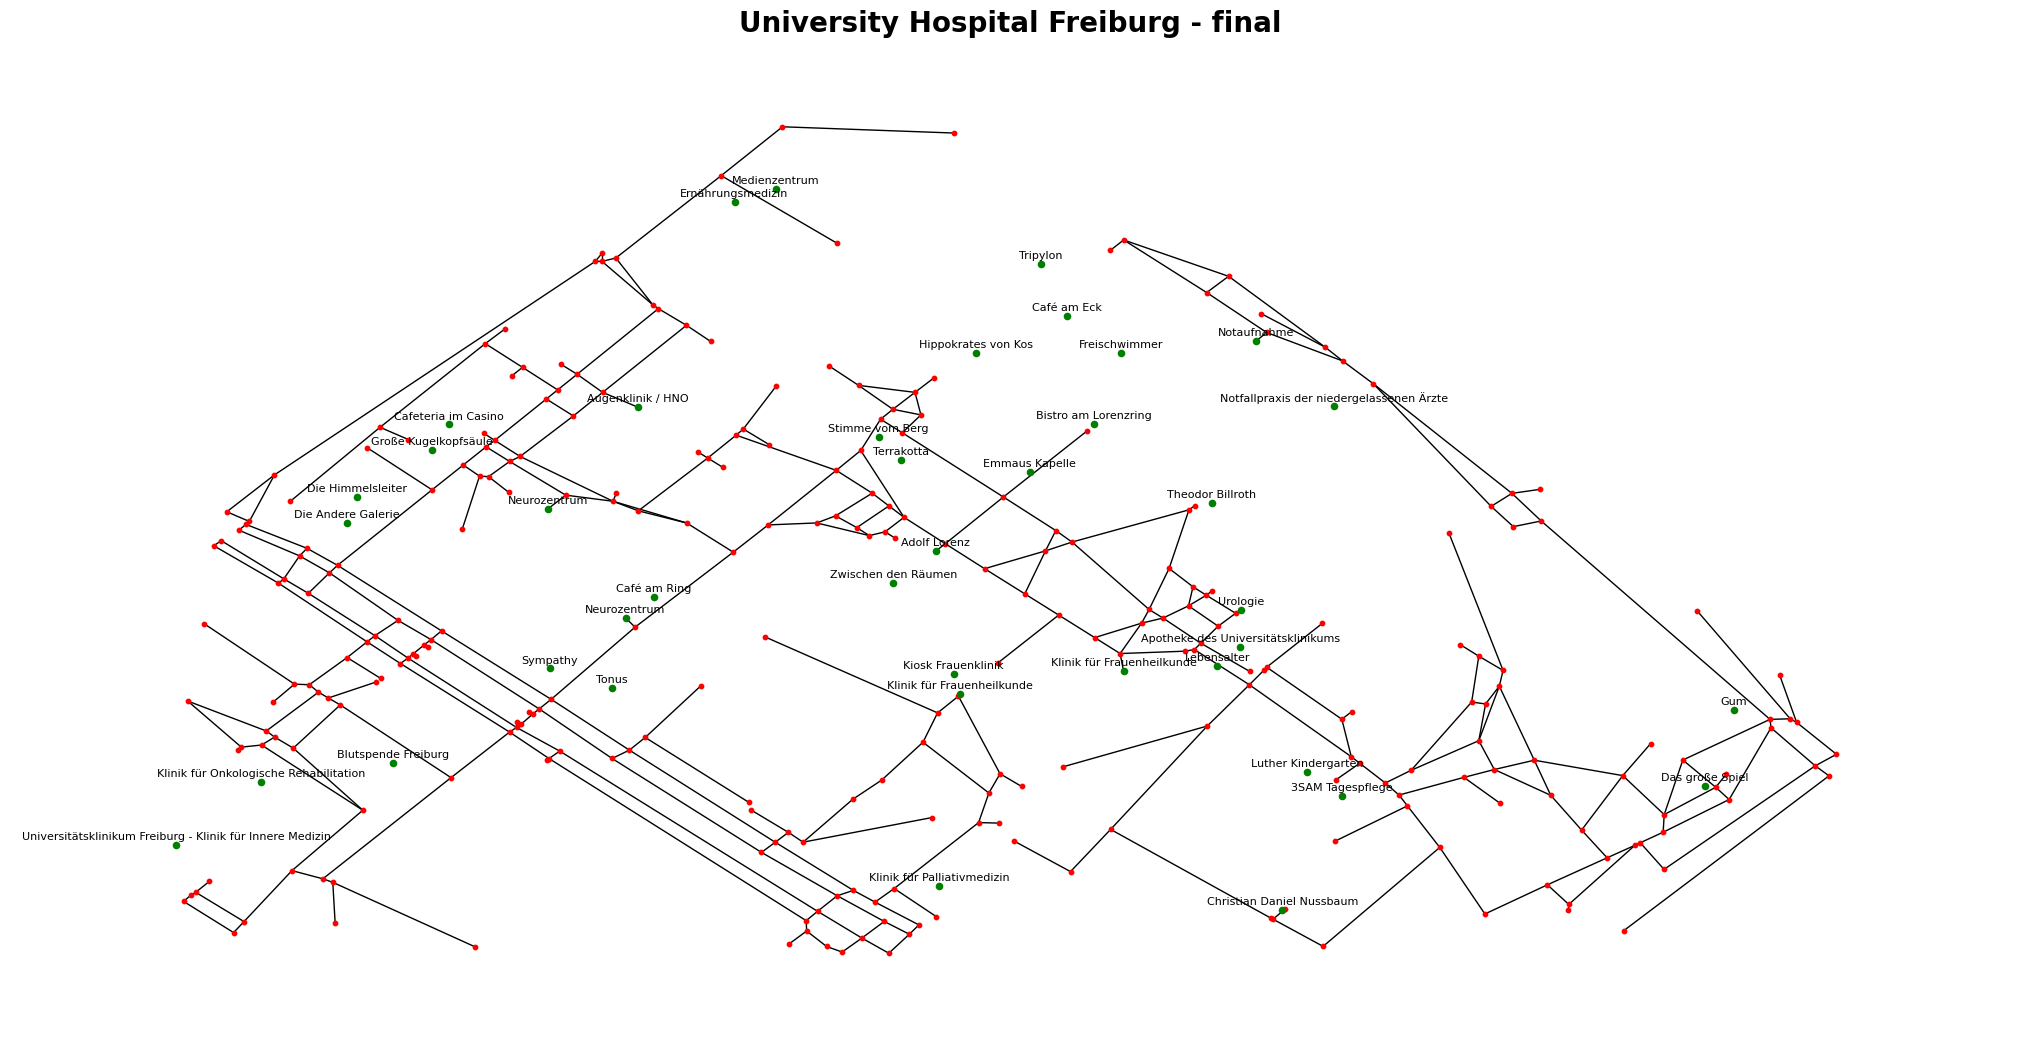

In [ ]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_final.nodes(data=True)}
pos_labels = {node: (data['x'], data['y'] + 0.00005) for node, data in G_final.nodes(data=True)}

# define colors for the different highway types
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'purple', 'pink', 'brown',
          'black', 'grey', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'maroon',
          'navy', 'olive', 'silver', 'aqua', 'fuchsia', 'lime', 'teal', 'lavender',
          'maroon', 'navy', 'olive', 'silver', 'aqua', 'fuchsia']

# plot
plt.figure(figsize=(20, 10))
nx.draw(G_final, with_labels=False, node_size=10, node_color='red', pos=pos, arrows=False)
# plot special nodes in green and label them with their name
nx.draw_networkx_nodes(G_final, nodelist = special_nodes_xml_index,
                       pos=pos, node_size=20, node_color='green')
nx.draw_networkx_labels(G_final, pos=pos_labels, labels= nx.get_node_attributes(G_final, 'name'), font_size=8)

# # label nodes with their id
# nx.draw_networkx_labels(G_final, pos=pos, labels={node: node for node in G_final.nodes}, font_size=8)

# # plot edges with different colors according to their surface type
# for i, surface in enumerate(set(nx.get_edge_attributes(G_final, 'surface').values())):
#     if surface is not None:
#         nx.draw_networkx_edges(G_final, pos=pos, edgelist=[k for k,v in nx.get_edge_attributes(G_final, 'surface').items() if v == surface],
#                                edge_color=colors[i], width=1.5)

plt.title('University Hospital Freiburg - final', fontsize=20, fontweight='bold')
#plt.legend(set(nx.get_edge_attributes(G_final, 'surface').values()), loc='upper left')
plt.show()

In [ ]:
print('The final graph has {} nodes and {} edges.'.format(G_final.number_of_nodes(), G_final.number_of_edges()))

The final graph has 329 nodes and 373 edges.
